In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tnrange, tqdm
from jax import random, vmap, jit, value_and_grad
from jax.experimental import optimizers, stax
import jax.numpy as np
import staxplusplus as spp
from normalizing_flows import *
from util import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# In this example, we will fit a normalizing flow to a spiral distribution

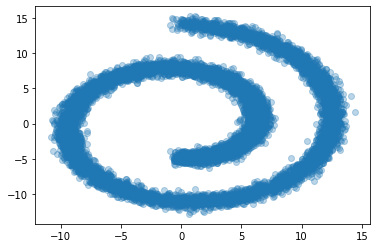

In [3]:
x, _ = make_swiss_roll(n_samples=10000, noise=0.5, random_state=0)
x = x[:,[0,2]]
# x = 0*x + random.normal(random.PRNGKey(0), x.shape)*4.0
plt.scatter(x[:,0], x[:,1], alpha=0.3)

# Build our normalizing flow

In [31]:
def NeuralSplineTransform(out_shape):
    layers = [spp.Dense(1024), spp.Relu()]*4
    return spp.sequential(*layers, spp.Dense(np.prod(out_shape)), spp.Reshape(out_shape))

def Transform(out_shape, n_hidden_layers=4, layer_size=1024):
    out_dim = out_shape[-1]
    # Build the s and t networks that xb will be fed into
    layer_sizes = [layer_size for _ in range(n_hidden_layers)]
    log_s_out = spp.sequential(spp.Dense(out_dim), spp.Tanh())
    t_out = spp.sequential(spp.Dense(out_dim))
    dense_layers = [spp.Dense(layer_size), spp.Relu()]*n_hidden_layers
    coupling_param_architecture = spp.sequential(*dense_layers, spp.FanOut(2), spp.parallel(log_s_out, t_out))

    # Split x into xa, xb and feed xb into its path
    return coupling_param_architecture

# flow = NeuralSpline(4, NeuralSplineTransform)

flow = sequential_flow(NeuralSpline(128, NeuralSplineTransform),
                       AffineCoupling(Transform),
                       Reverse(),
                       NeuralSpline(128, NeuralSplineTransform),
                       AffineCoupling(Transform),
                       Reverse(),
                       NeuralSpline(128, NeuralSplineTransform),
                       AffineCoupling(Transform),
                       Reverse(),
                       NeuralSpline(128, NeuralSplineTransform),
                       AffineCoupling(Transform),
                       Reverse(),
                       UnitGaussianPrior())

# Initialize our model

In [32]:
key = random.PRNGKey(0)
init_fun, forward, inverse = flow
# forward = jit(forward)

names, output_shape, params, state = init_fun(key, x.shape[1:], ())

In [33]:
forward(params, state, np.zeros(1), x[5], (), key=key, test=TEST)

(DeviceArray([-67.71361], dtype=float32),
 DeviceArray([ -1.9237148, -11.335115 ], dtype=float32),
 (((), (), (), (), (), (), (), (), (), ()),
  ((), (), (), (), (), (), (), (), (), (((), ()), ((),))),
  (),
  ((), (), (), (), (), (), (), (), (), ()),
  ((), (), (), (), (), (), (), (), (), (((), ()), ((),))),
  (),
  ((), (), (), (), (), (), (), (), (), ()),
  ((), (), (), (), (), (), (), (), (), (((), ()), ((),))),
  (),
  ((), (), (), (), (), (), (), (), (), ()),
  ((), (), (), (), (), (), (), (), (), (((), ()), ((),))),
  (),
  ()))

# The loss function will be the negative mean log likelihood

In [34]:
@partial(jit, static_argnums=(0,))
def nll(forward, params, state, x, **kwargs):
    cond = ()
    log_px, z, updated_state = forward(params, state, np.zeros(x.shape[0]), x, cond, **kwargs)
    return -np.mean(log_px), updated_state

# Create the gradient function
valgrad = value_and_grad(partial(nll, forward), has_aux=True)
valgrad = jit(valgrad)

# The last step before training is creating our optimizers

In [37]:
opt_init, opt_update, get_params = optimizers.adam(1e-4)
opt_update = jit(opt_update)
opt_state = opt_init(params)

# Next, we'll train the model

In [38]:
batch_size = 64

losses = []
pbar = tnrange(20000)
for i in pbar:
    key, *keys = random.split(key, 3)
    
    batch_idx = random.randint(keys[0], (batch_size,), minval=0, maxval=x.shape[0])
    x_batch = x[batch_idx,:]
    
    params = get_params(opt_state)
    (val, state), grad = valgrad(params, state, x_batch, key=keys[1], test=TRAIN)
    opt_state = opt_update(i, grad, opt_state)
    
    losses.append(val)
    pbar.set_description('Negative Log Likelihood: %5.3f'%(val))

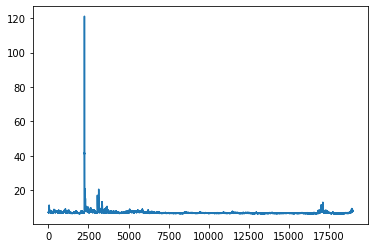

In [39]:
plt.plot(losses[1000:])

# See how well the model fit the data

In [40]:
std = 0.3
n_importance_samples = 8

# Create a density plot of the data
x_grid_samples, y_grid_samples = 64, 64
x_range = np.linspace(-20, 20, x_grid_samples)
y_range = np.linspace(-20, 20, y_grid_samples)
X, Y = np.meshgrid(x_range, y_range)
grid = np.dstack([X, Y]).reshape((-1, 2))

# Evaluate the density of the grid
log_px, _, _ = forward(params, state, np.zeros(grid.shape[:-1]), grid, (), test=TEST, key=key, std=std, n_importance_samples=n_importance_samples)

# Reshape the densities
Z = np.exp(log_px).reshape((x_grid_samples, y_grid_samples))

# Project the original data points into the latent space
_, z, _ = forward(params, state, np.zeros_like(x[:500,0]), x[:500], (), test=TEST, key=key, std=std, n_importance_samples=n_importance_samples)

# Pull some samples from a unit Gaussian
eps = random.normal(key, (500, x.shape[-1]))
_, f_eps, _ = inverse(params, state, np.zeros((500,)), eps, (), test=TEST, key=key, std=std, n_importance_samples=n_importance_samples)

Text(0.5, 1.0, 'Learned Samples')

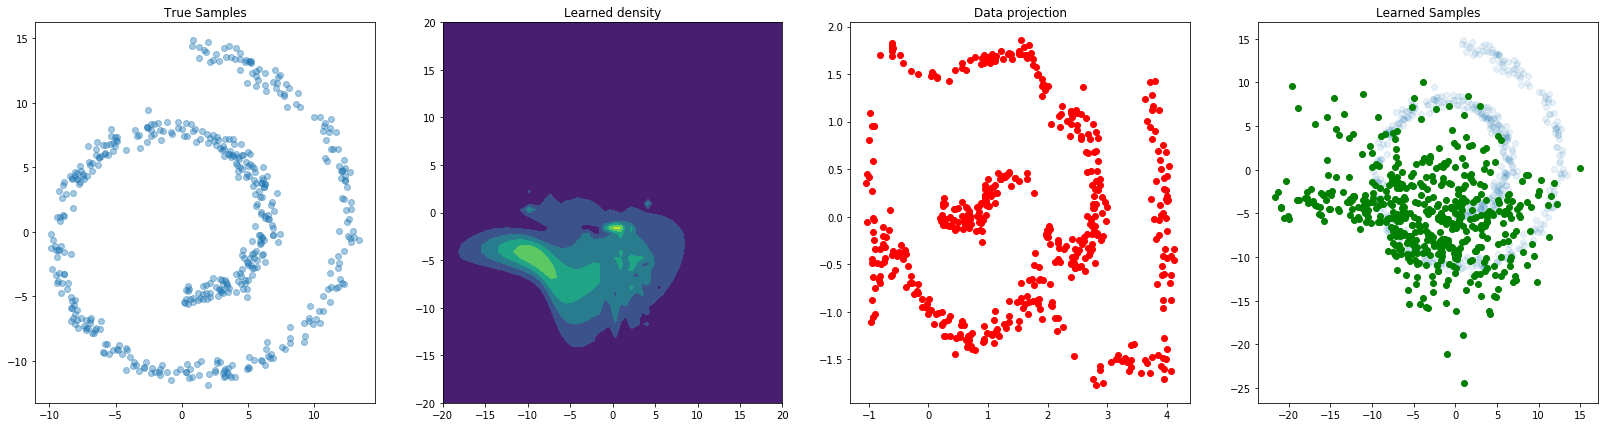

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(28, 7)

ax1.scatter(x[:500,0], x[:500,1], alpha=0.4)
ax1.set_title('True Samples')

ax2.contourf(X, Y, Z, cmap='viridis')
ax2.set_title('Learned density')

ax3.scatter(z[:,0], z[:,1], color='red')
ax3.set_title('Data projection')

ax4.scatter(x[:500,0], x[:500,1], alpha=0.1)
ax4.scatter(f_eps[:,0], f_eps[:,1], color='green')
ax4.set_title('Learned Samples')
# ax4.set_xlim(-20, 20)
# ax4.set_ylim(-20, 20)

In [42]:
def posterior_sample(key, x, n_importance_samples=8, std=0.3):
    _, z, _ = forward(params, state, np.zeros_like(x), x, (), test=TEST, key=key, std=std, n_importance_samples=n_importance_samples)
    return z

In [43]:
keys = np.array(random.split(key, 32))
z_posterior = vmap(vmap(posterior_sample, in_axes=(0, None)), in_axes=(None, 0))(keys, x[:10])

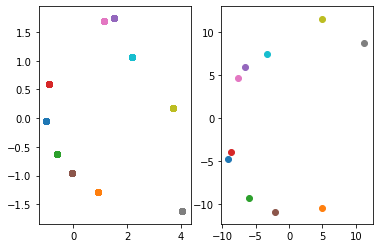

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
for i in range(z_posterior.shape[0]):
    ax1.scatter(z_posterior[i,:,0], z_posterior[i,:,1])
    ax2.scatter(x[i,0], x[i,1])